In [7]:
# General imports
import numpy as np
import random
from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister, transpile

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Get a fake backend from the fake provider
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# Parameterized circuit
from qiskit.circuit import Parameter

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings("ignore")


SparsePauliOp(['IZZ', 'ZZI', 'IIX', 'IXI', 'XII'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])

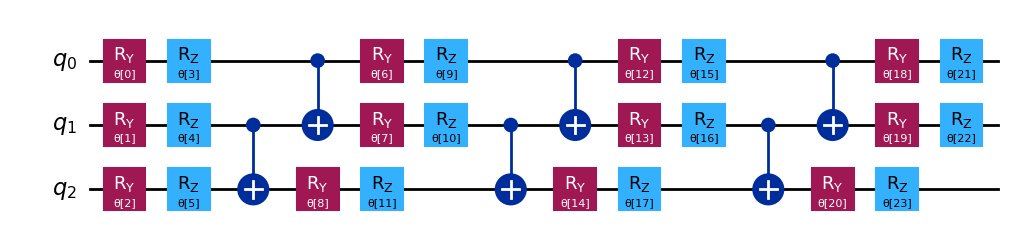

In [8]:
# Define Spin-1/2 Hamiltonian and Variational Ansatz
num_sites = 3
J = 1
h = -1

oplist = []
for i in range(num_sites-1):
    oplist.append(("ZZ",[i,i+1],J))
for i in range(num_sites):
    oplist.append(("X",[i],h))    

hamiltonian = SparsePauliOp.from_sparse_list([*oplist], num_qubits=num_sites)
display(hamiltonian)
ansatz = EfficientSU2(hamiltonian.num_qubits)
display(ansatz.decompose().draw("mpl", style="iqp"))
num_params = ansatz.num_parameters

In [9]:
# Defien free energy calculation to be minimize based on ansatz parameters
def cost_func(params, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler):
    free_energy = 0
    
    # Expectation value of H
    e_pub = (ansatz, [hamiltonian], [params])
    energy = estimator.run(pubs=[e_pub]).result()[0].data.evs[0]
    free_energy += energy-3/(2*beta)

    n_shots = 1024

    # Calculation and post-processing of Tr(rho^2)
    s_pub = (tr_rho2,[params],n_shots)
    job2 = sampler.run(pubs=[s_pub]).result()[0].data.clbit.get_counts()
    try: 
        R2 = job2['0']/n_shots - job2['1']/n_shots
    except:
        R2 = 1
    free_energy += (2/beta)*R2
    
    # Calculation and post-processing of Tr(rho^3)
    s_pub = (tr_rho3,[params],n_shots)
    job3 = sampler.run(pubs=[s_pub]).result()[0].data.clbit.get_counts()
    try: 
        R3 = job3['0']/n_shots - job3['1']/n_shots
    except:
        R3 = 1
    free_energy += (-1/(2*beta))*R3

    return free_energy


In [10]:
# Define Callback Function
def build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback    


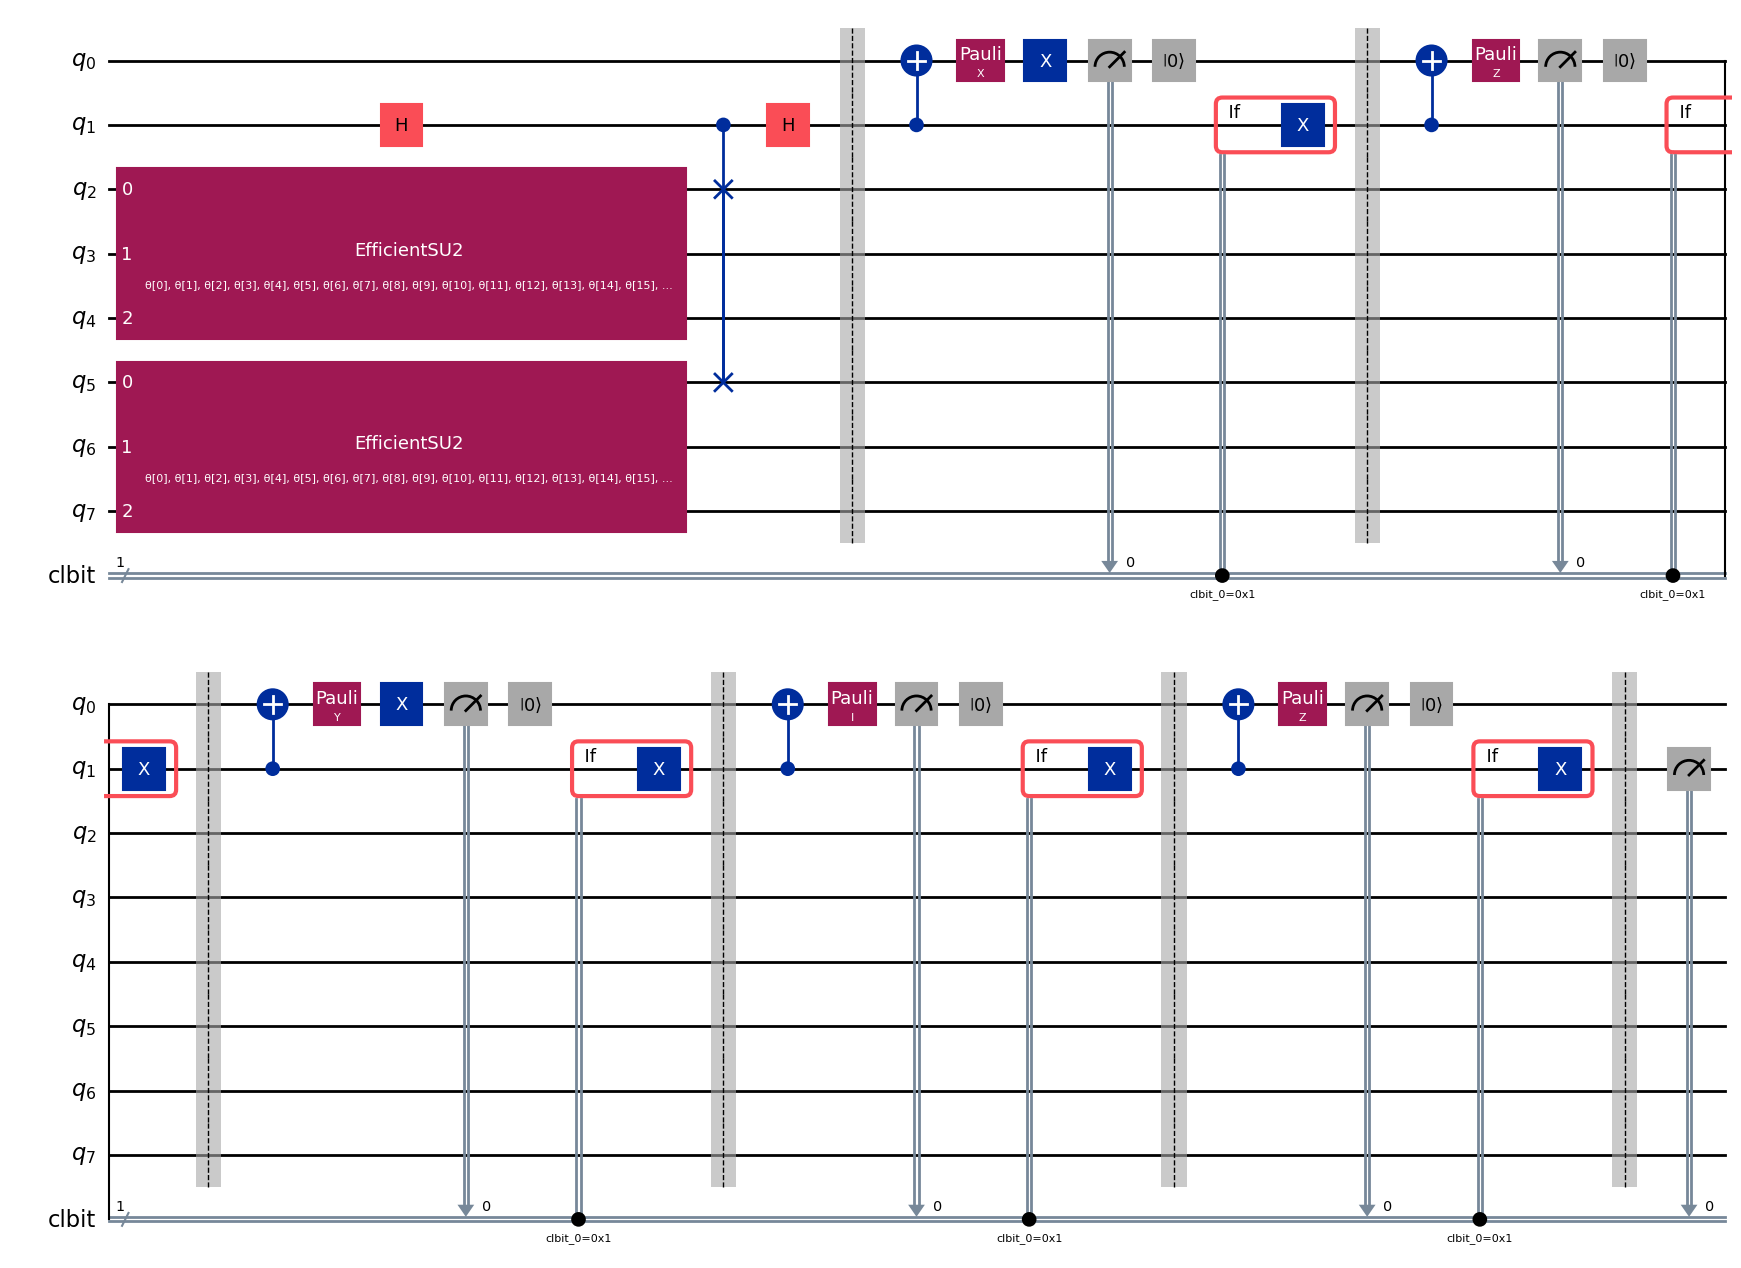

In [11]:
# Define SWAP test circuit used in Tr(rho^2) calcultion

qubits = QuantumRegister(2)
clbits = ClassicalRegister(1,'clbit')

auxs = QuantumCircuit(qubits,clbits)

tr_rho2 = QuantumCircuit(2*num_sites+2)
tr_rho2 = tr_rho2.compose(auxs, [0,1])
tr_rho2.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)
tr_rho2.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho2.h(1)
tr_rho2.cswap(1,2,num_sites+2)
tr_rho2.h(1)

tr_rho2.barrier()

N = 5
pauli_list = ['I','X','Y','Z']
for i in range(N):
    tr_rho2.cx(1,0)
    rand_pauli = random.choice(pauli_list)
    tr_rho2.pauli(rand_pauli,[0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho2.x(0)
    tr_rho2.measure(0,0)
    tr_rho2.reset(0)
    with tr_rho2.if_test((0, 1)):
        tr_rho2.x(1)
    tr_rho2.barrier()

tr_rho2.measure(1,0)

display(tr_rho2.draw("mpl", style="iqp"))


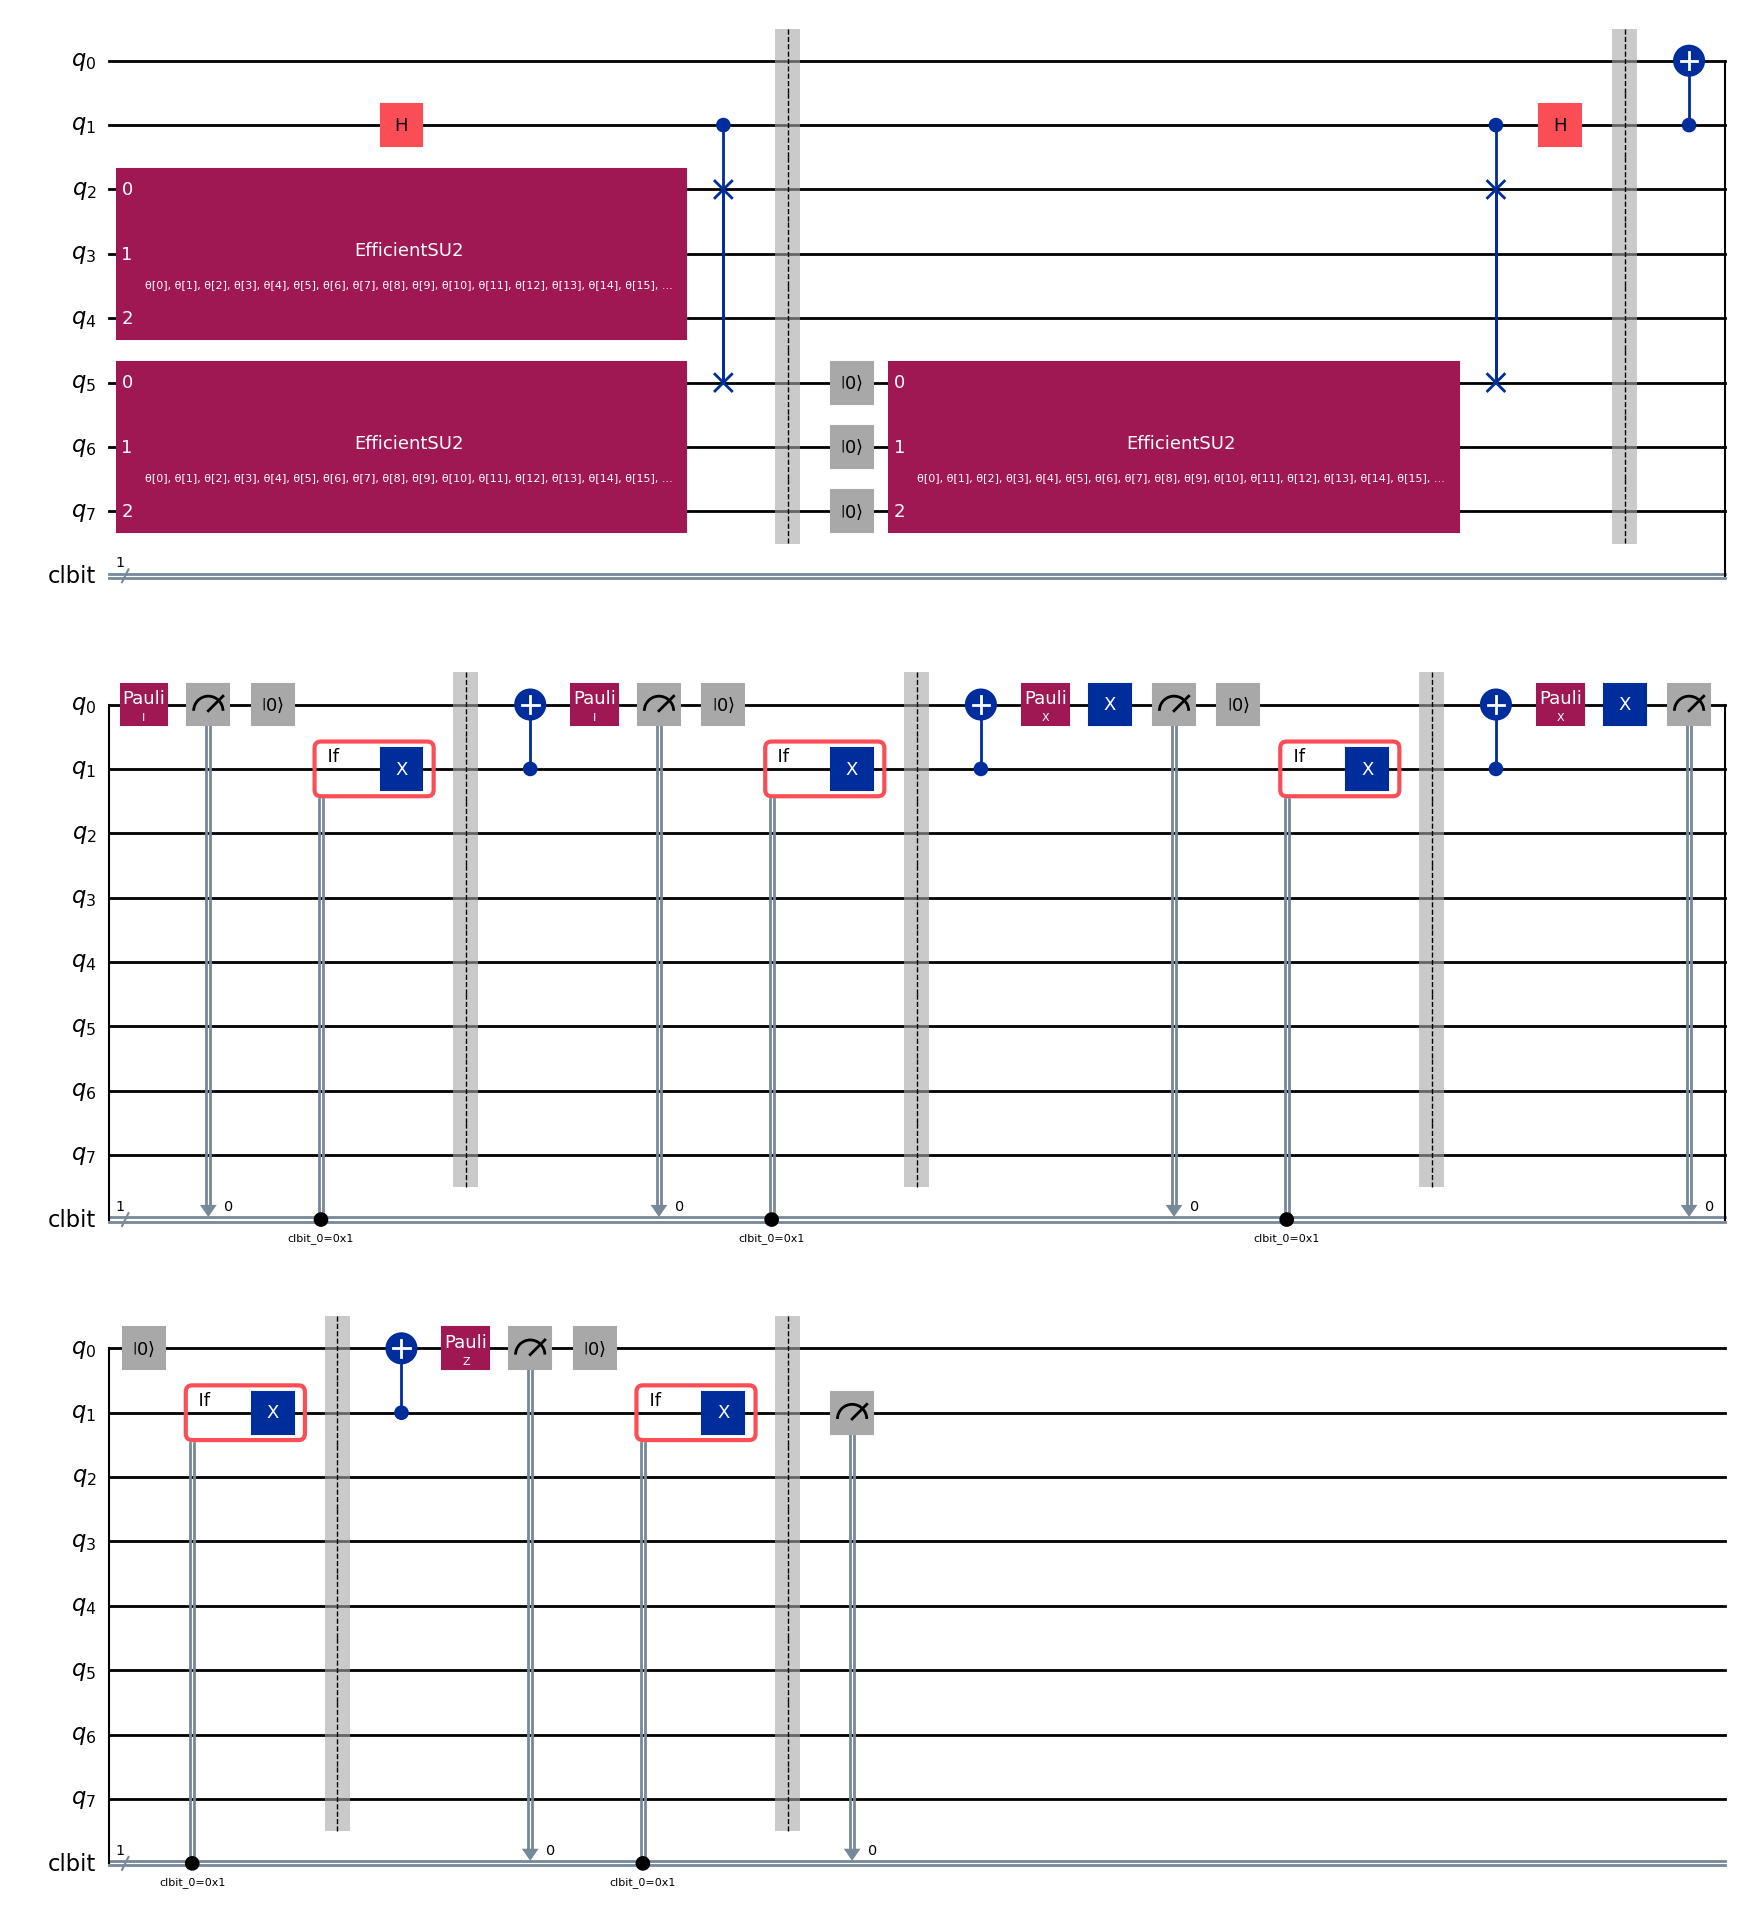

In [12]:
# Define SWAP test circuit used in Tr(rho^3) calcultion using mid-circuit measurment and reset
qubits = QuantumRegister(2)
clbits = ClassicalRegister(1,'clbit')

auxs = QuantumCircuit(qubits,clbits)

tr_rho3 = QuantumCircuit(2*num_sites+2)
tr_rho3 = tr_rho3.compose(auxs, [0,1])
tr_rho3.compose(ansatz, [i+2 for i in range(num_sites)], inplace=True)
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.h(1)
tr_rho3.cswap(1,2,num_sites+2)
tr_rho3.barrier()
tr_rho3.reset([2+num_sites+i for i in range(num_sites)])
tr_rho3.compose(ansatz, [i+2+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.cswap(1,2,num_sites+2)
tr_rho3.h(1)

tr_rho3.barrier()

N = 5
pauli_list = ['I','X','Y','Z']
for i in range(N):
    tr_rho3.cx(1,0)
    rand_pauli = random.choice(pauli_list)
    tr_rho3.pauli(rand_pauli,[0])
    if rand_pauli == 'X' or rand_pauli == 'Y':
        tr_rho3.x(0)
    tr_rho3.measure(0,0)
    tr_rho3.reset(0)
    with tr_rho3.if_test((0, 1)):
        tr_rho3.x(1)
    tr_rho3.barrier()

tr_rho3.measure(1,0)

display(tr_rho3.draw("mpl", style="iqp"))


In [17]:
# For running local Simulation
local = True
if local:
    # Specify a system to use for the noise model
    service = QiskitRuntimeService(channel="ibm_quantum", token="6061d826942e751f9193e4cecf3ac65c23c16ea9a0d0aa1cbc5928384996d7421586e00dba3048fc395ccb0ca2445c9469d0b78eb328b437131e8c38882518ee")
    real_backend = service.backend("ibm_kyoto")
    backend = AerSimulator.from_backend(real_backend)
    # backend = AerSimulator()
    # backend = GenericBackendV2(num_qubits=2*num_sites+2,control_flow=True)
    display(f"Local Simulator Backend: {backend.name}")
else:
    # To run on hardware, select the backend with the fewest number of jobs in the queue
    service = QiskitRuntimeService(channel="ibm_quantum", token="6061d826942e751f9193e4cecf3ac65c23c16ea9a0d0aa1cbc5928384996d7421586e00dba3048fc395ccb0ca2445c9469d0b78eb328b437131e8c38882518ee")
    #service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.least_busy(operational=True, simulator=False)
    display(f"Quantum Cloud Backend: {backend.name}")

"Local Simulator Backend: 'aer_simulator(ibm_kyoto)"

In [18]:
# Minimize the cost function with respect to the ansatz parameters

callback_dict = {
    "prev_vector": {},
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)
beta = 1.5

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
ansatz_isa = pm.run(ansatz)
tr_rho2_isa = pm.run(tr_rho2)
tr_rho3_isa = pm.run(tr_rho3)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

if local:
    estimator = Estimator(backend=backend)
    sampler = Sampler(backend=backend)
   
    callback = build_callback(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler, callback_dict)
    
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler),
        method="cobyla",
        callback=callback,
        options={'maxiter':400}
    )
else:
    with Session(backend=backend) as session:
        estimator = Estimator(session=session)
        sampler = Sampler(session=session)
       
        callback = build_callback(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler, callback_dict)
        
        res = minimize(
            cost_func,
            x0,
            args=(ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler),
            method="cobyla",
            callback=callback,
            options={'maxiter':1}
        )
display(f'Calculated Free Energy: {cost_func(res.x, ansatz_isa, tr_rho2_isa, tr_rho3_isa, hamiltonian_isa, beta, estimator, sampler)}')



'Calculated Free Energy: -2.760904947916667'

In [94]:
import qiskit
qiskit.version.get_version_info()

'1.0.2'

In [95]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.23.0'